# Ensemble Learning: Heart Disease Dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss, classification_report

warnings.filterwarnings('ignore')

# Data Loading

loading data from kaggle database: Heart Disease Dataset

!pip install kaggle
!kaggle datasets download -d fedesoriano/heart-failure-prediction

import zipfile

with zipfile.ZipFile('heart-failure-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [36]:
df = pd.read_csv('heart.csv')
#df.head()

In [37]:
# A summarization of features invloved: 11 features, 1 output (HeartDisease)
df.info() 
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

# Feature Engineering
Since we are mostly interested in the tree models, no standarization is needed for the numerical data, we will transform categorical features using one hot encoder. We will first select all categorical data and transform them using One Hot Encoder.

In [38]:
# Select categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Select columns with 10 or fewer unique values
low_unique_cols = [col for col in df.columns if df[col].nunique() <= 10 and df[col].nunique() > 2]

cat_col = list(set(categorical_cols) | set(low_unique_cols))

# One hot encoder
df = pd.get_dummies(df, columns=cat_col, drop_first=True)

#df.info()


# Data Mining and Preprocessing
## Checking Target Variable Balance

In [39]:
df['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

## Distribution of Numerical Features

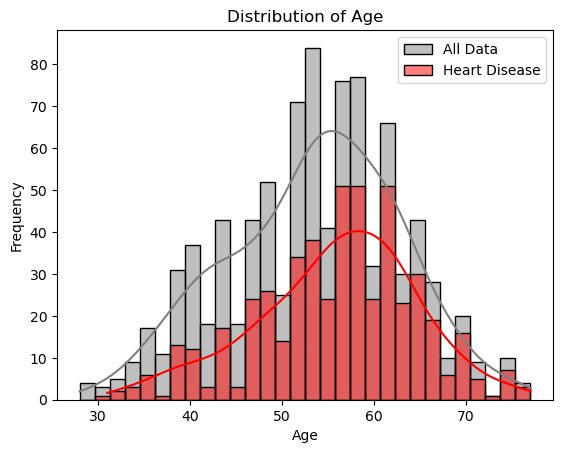

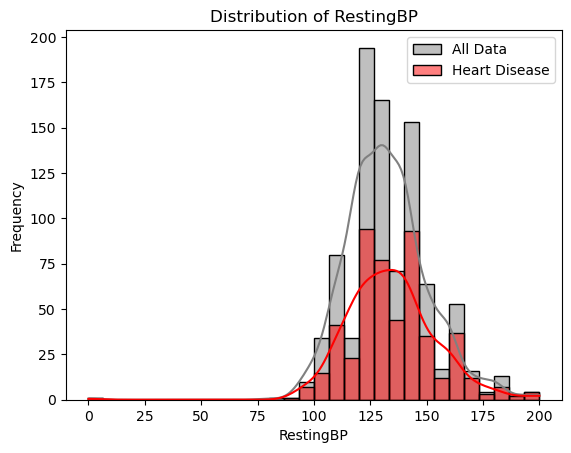

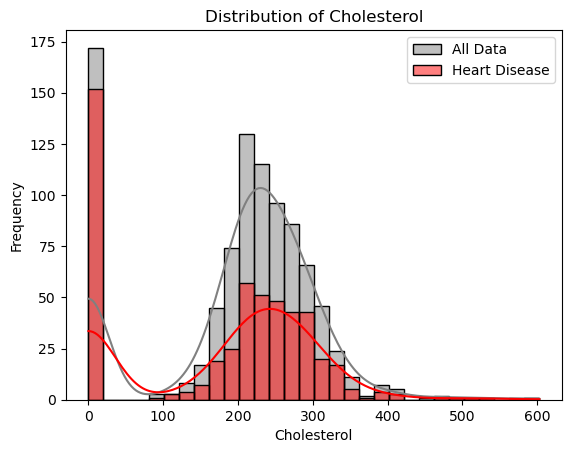

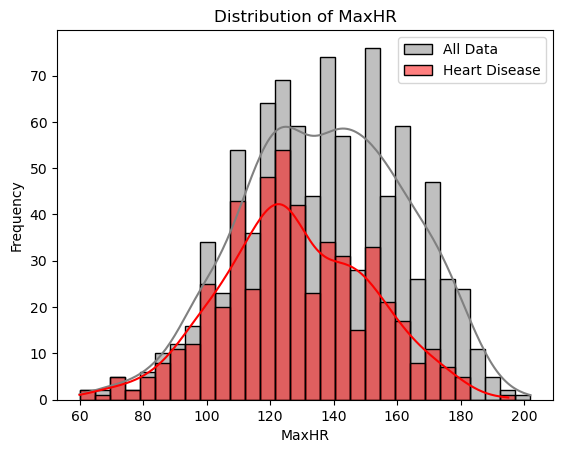

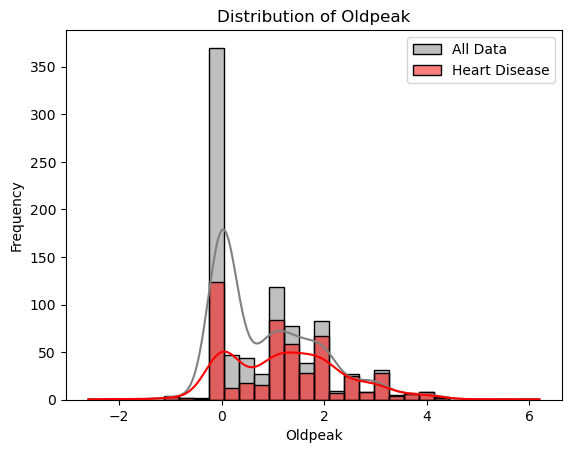

In [40]:
for col in [col for col in df.columns if df[col].nunique() > 10]:
    # Define consistent bins based on the data range
    bin_edges = np.histogram_bin_edges(df[col], bins=30)  # Get bin edges for 30 bins

    # Full data histogram
    sns.histplot(
        df[col], 
        kde=True, bins=bin_edges, color='gray', 
        edgecolor='black', label='All Data', alpha=0.5
    )
    
    # Histogram for patients with heart disease
    sns.histplot(
        df[df["HeartDisease"] == 1][col], 
        kde=True, bins=bin_edges, color='red', 
        edgecolor='black', label='Heart Disease', alpha=0.5
    )
    
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()  # Add legend to distinguish the groups
    plt.show()


### Findings

Analysis of the cholesterol distribution revealed missing values for some patients. This highlights the need to address incomplete data, either by imputation or exclusion, to ensure the accuracy of subsequent analyses. In this case, we choose to impute the missing value using KNN Imputer.

## Data Imputation

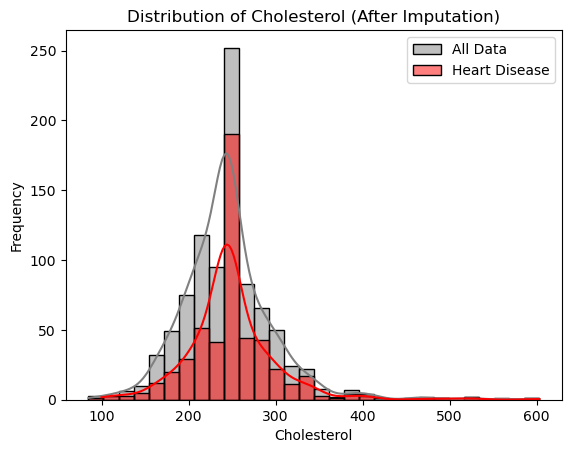

In [41]:
df['Cholesterol'].replace(0, np.nan, inplace=True)


imputer = KNNImputer(n_neighbors=5)
df['Cholesterol'] = imputer.fit_transform(df[['Cholesterol']])

#plot the new Cholesterol 
bin_edges = np.histogram_bin_edges(df['Cholesterol'], bins=30)  # Get bin edges for 30 bins

sns.histplot(
        df['Cholesterol'], 
        kde=True, bins=bin_edges, color='gray', 
        edgecolor='black', label='All Data', alpha=0.5
    )
    
    # Histogram for patients with heart disease
sns.histplot(
        df[df["HeartDisease"] == 1]['Cholesterol'], 
        kde=True, bins=bin_edges, color='red', 
        edgecolor='black', label='Heart Disease', alpha=0.5
    )
    
plt.title(f'Distribution of Cholesterol (After Imputation)')
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')
plt.legend()  # Add legend to distinguish the groups
plt.show()

## Correlation Matrix

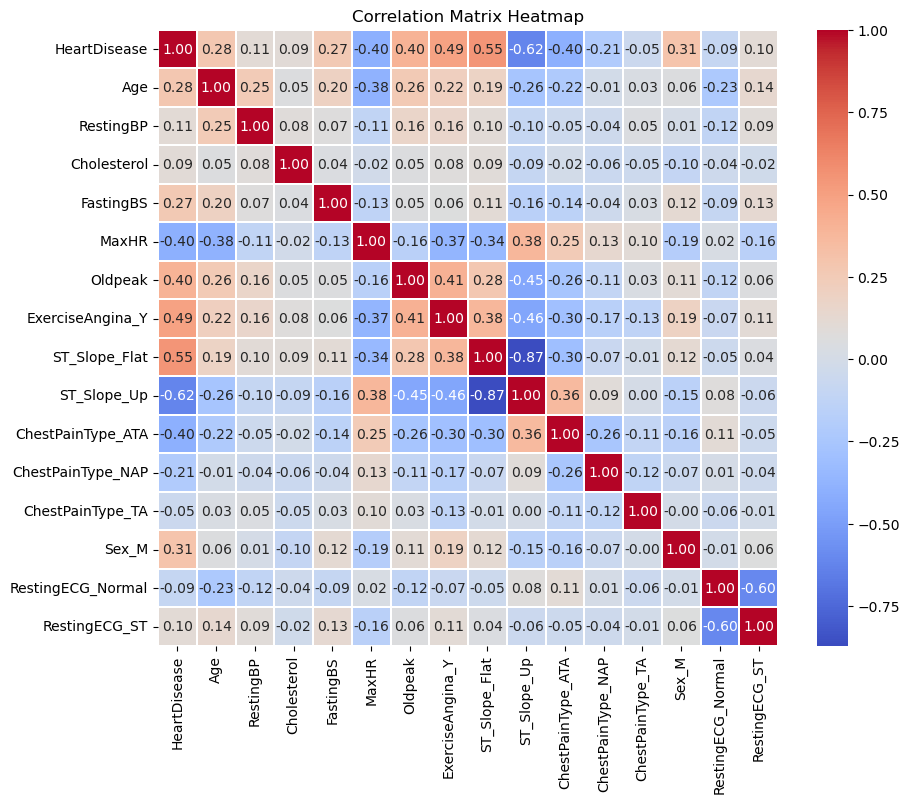

In [6]:
cols = ['HeartDisease'] + [col for col in df.columns if col != 'HeartDisease']
corr_matrix = df[cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.3, cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Findings

The correlation matrix revealed that Oldpeak, ExerciseAngina, and ST_Slope_Flat exhibit stronger correlations with other variables compared to the rest. These variables may have more substantial relationships with the outcome or other predictors, warranting further exploration in subsequent analyses. Specifically, the correlation between Oldpeak and other features could indicate potential patterns related to heart disease, while ExerciseAngina and ST_Slope_Flat seem to provide important insights into exercise tolerance and ECG findings.

# Model Training: Decision Tree, Random Forrest and XGBoosting

## Splitting the Dataset into Training and Testing Data (0.8:0.2)

In [7]:
x =  df.drop(columns='HeartDisease')
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)

## Decision Tree Model: Tuning and Evaluation

In this section, we use the grid search method to find the optimal hyperparameters for the decision tree model.

In [9]:
# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42, criterion = 'entropy')

# Define the parameter grid to search over
param_grid = {
    'max_depth': [3, 5, None],  # Tree depth options
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],      # Minimum samples required to be in a leaf
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when splitting
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model with the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")

# Use the best model to make predictions
st_best_model = grid_search.best_estimator_
joblib.dump(st_best_model, 'DecisionTree_best.pkl')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.8360


['DecisionTree_best.pkl']

## Random Forest Model: Tuning and Evaluation

In this section, we use the Bayesian Optimization method to find the optimal hyperparameters for the random forest model.

In [10]:
rf = RandomForestClassifier(random_state=42, criterion = 'entropy')

# Define the parameter search space

search_space = {
    'n_estimators': (100, 1000),  # Range for n_estimators
    'max_depth': [3, 5, None],    # Range for max_depth
    'min_samples_split': (2, 10), # Range for min_samples_split
    'min_samples_leaf': (1, 10),  # Range for min_samples_leaf
}

bayes_search = BayesSearchCV(estimator=rf, search_spaces=search_space, n_iter=50, cv=5, scoring='accuracy', random_state=42)

# Fit the model with the Bayesian Optimization search
bayes_search.fit(X_train, y_train)

joblib.dump(bayes_search.best_estimator_ , 'RandomForest_best.pkl')

['RandomForest_best.pkl']

##  Xgboost model: Tuning and Evaluation

In [11]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],         # Number of boosting rounds (trees)
    'max_depth': [3, 5],                  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.3],      # Step size for each tree
    'subsample': [0.8, 0.9, 1.0],            # Fraction of training data used for each tree
    'colsample_bytree': [0.8, 0.9, 1.0],    # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.3],                 # Minimum loss reduction to make a further partition
    'min_child_weight': [1, 3, 5],           # Minimum number of samples per leaf
    'alpha': [0, 0.1, 0.5],                 # L1 regularization
    'lambda': [0, 0.1, 1],                  # L2 regularization
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the model to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Save the model
xgb_best_model = grid_search.best_estimator_
joblib.dump(xgb_best_model, 'XGBoost_best.pkl')

Fitting 5 folds for each of 13122 candidates, totalling 65610 fits
Best Parameters: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 0, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8851351351351351


['XGBoost_best.pkl']

# Model Evaluation
Next we evaluate our three tuned models using our test data set. We will summarize the performance of three trained machine learning models -- Decision Tree, Random Forest, and XGBoosting -- evaluated on a testing dataset. The evaluation metrics include Accuracy, Precision, Recall, F1-Score, Area Under the Curve (AUC), Log Loss, and Confusion Matrix.

In [18]:
Decision_Tree = joblib.load('DecisionTree_best.pkl')
Random_Forest = joblib.load('RandomForest_best.pkl')
XGBoosting = joblib.load('XGBoost_best.pkl')

model = [Decision_Tree, Random_Forest, XGBoosting]
metrics = []

for mdl in model:
    model_name = [name for name, obj in globals().items() if obj is mdl][0]
    
    y_pred = mdl.predict(X_test)
    y_pred_prob = mdl.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_prob)
    
    metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Log Loss': logloss,
        'Confusion Matrix': cm
    })
    
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

           Model  Accuracy  Precision    Recall  F1-Score       AUC  Log Loss  \
0  Decision_Tree  0.786395   0.839895  0.769231  0.803011  0.846843  0.761561   
1  Random_Forest  0.859864   0.877108  0.875000  0.876053  0.917064  0.384878   
2     XGBoosting  0.855782   0.883663  0.858173  0.870732  0.914908  0.375307   

         Confusion Matrix  
0  [[258, 61], [96, 320]]  
1  [[268, 51], [52, 364]]  
2  [[272, 47], [59, 357]]  


## Conclusion
Random Forest emerged as the most robust model based on its superior performance across most metrics, including Accuracy, Recall, F1-Score, AUC, and Log Loss. It is recommended for tasks prioritizing balanced performance between identifying positive and negative cases.

XGBoosting is a strong alternative with slightly higher precision but marginally lower recall and Log Loss compared to Random Forest. It may be preferable in scenarios prioritizing precision.

The Decision Tree, while less performant overall, remains an interpretable and computationally efficient option, making it suitable for use cases with resource constraints or explainability requirements.

# Feature importance analysis
Random Forest and Decision Tree models inherently provide feature importance scores based on how much each feature contributes to reducing the impurity, (in our case, the cross entropy), or improving the model's predictive performance. This analysis helps identify the most influential features in the dataset.

## Feature importances: the Decision Tree model

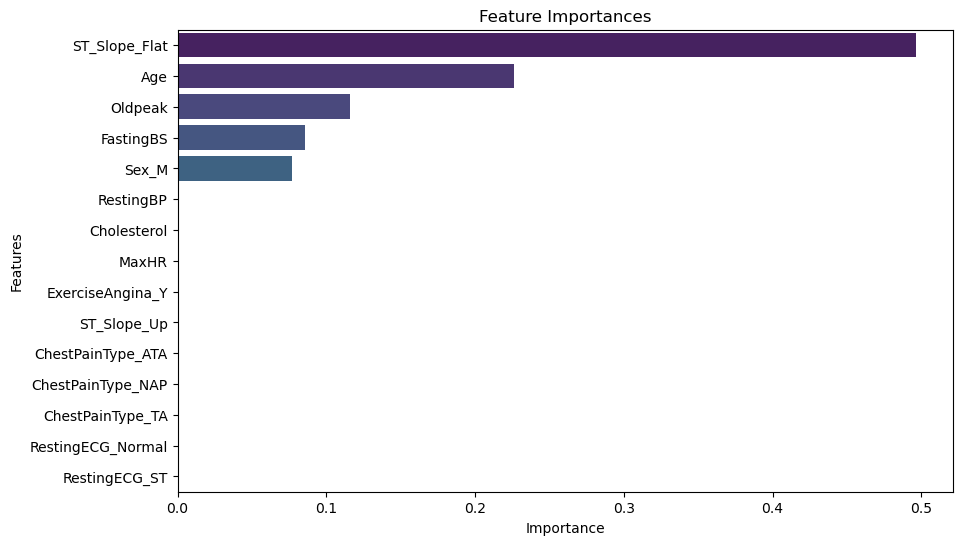

In [14]:
# Feature importances Decision Tree

importances_dtc = st_best_model.feature_importances_

feature_importance_dtc = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_dtc
})

# Sort values Feature importances
feature_importance_dtc = feature_importance_dtc.sort_values(by='Importance',ascending=False)

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature',
            data=feature_importance_dtc,
            palette='viridis')

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()

After evaluating feature importance of our decision tree model, the following features have the highest feature importance scores: ST_slope_Flat (the slope of the peak exercise ST segment is flat), Age, Oldpeak (ST depression induced by exercise relative to rest), FastingBS (fasting blood sugar) and Sex. 

## Visualization of the decision tree

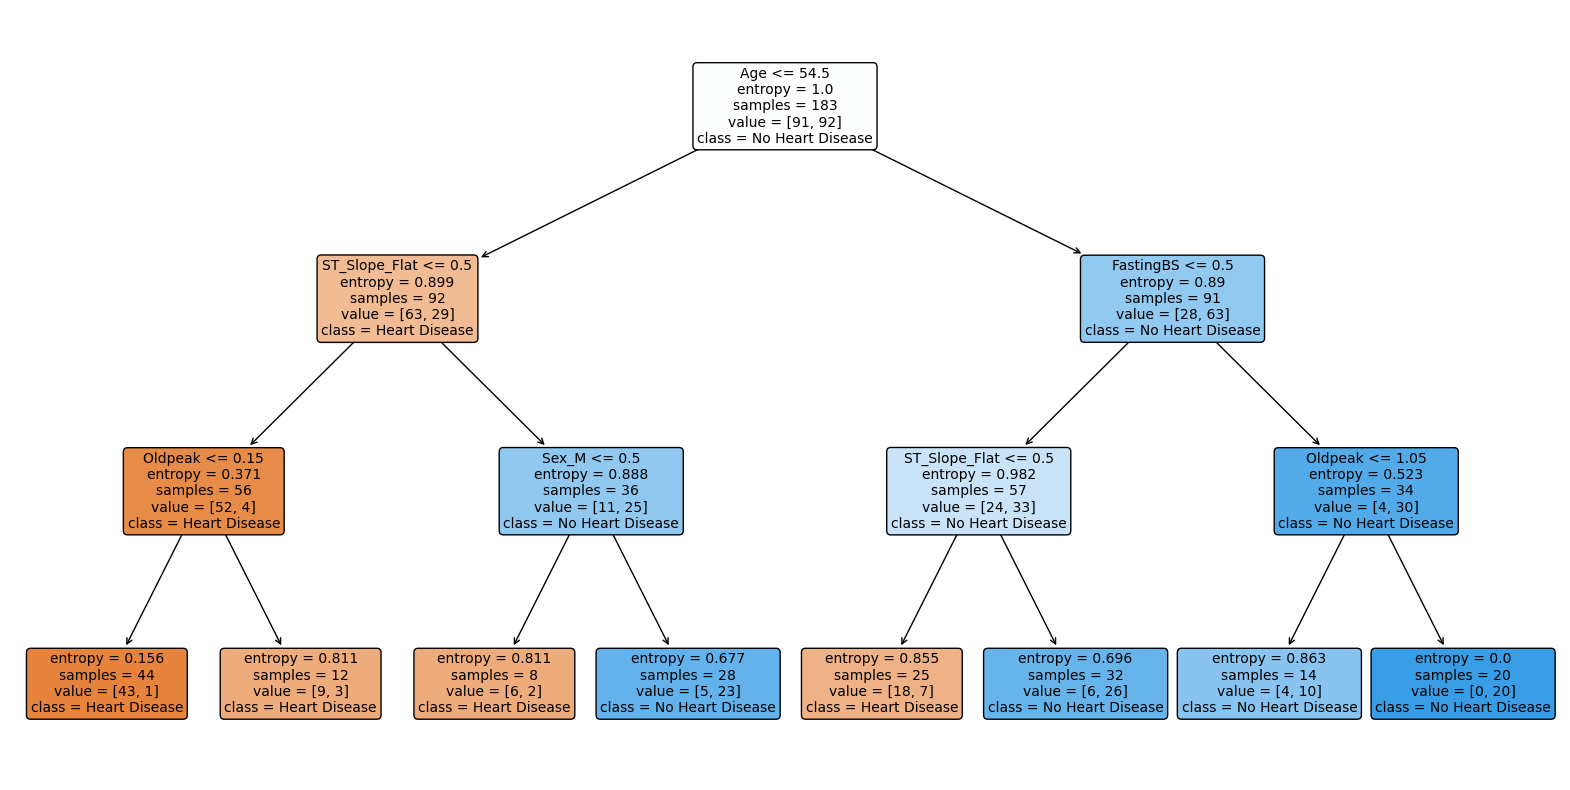

In [29]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Check if the best model is a DecisionTreeClassifier
if hasattr(st_best_model, 'tree_'):  # Ensure it's a decision tree
    plt.figure(figsize=(20, 10))  # Adjust size as needed
    plot_tree(st_best_model, 
              feature_names=list(X_train.columns),  # Replace with feature names if using a DataFrame
              class_names = ['Heart Disease', 'No Heart Disease'],
              filled=True, 
              rounded=True, 
              fontsize=10)
    plt.show()
else:
    print("The best model is not a Decision Tree.")

## Feature importances Analysis: the Random Forest Model

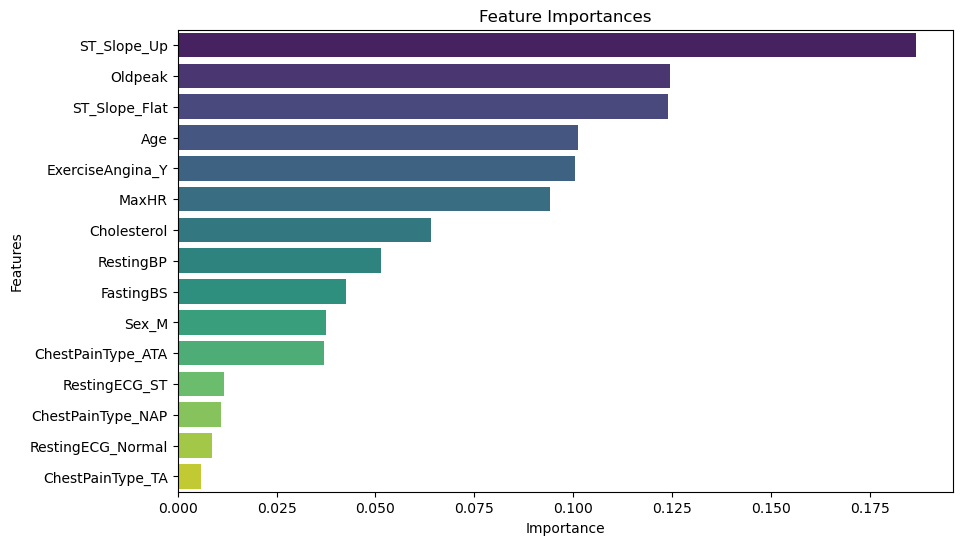

In [16]:
# Feature importances Decision Tree
importances_rfc = Random_Forest.best_estimator_ .feature_importances_

feature_importances_rfc = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_rfc
})

# Sort values Feature importances
feature_importances_rfc = feature_importances_rfc.sort_values(by='Importance',ascending=False)

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature',
            data=feature_importances_rfc,
            palette='viridis')

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.show()

After evaluating feature importance of our random forest model, the following features have the highest feature importance scores: ST_slope  (the slope of the peak exercise ST segment), Oldpeak (ST depression induced by exercise relative to rest), Age, ExerciseAngina (exercise induced angina) and MaxHR (maximum heart rate).

## Findings

After evaluating feature importance, the following key insights were observed:

### Top Features Across Models

The slope of the peak exercise ST segment (ST_slope, includes ST_slope_Flat and ST_slope_Up after encoding): Contributed significantly to both models, suggesting its critical role in determining heart disease.

Age and ST depression induced by exercise relative to rest (Oldpeak) also showed high importance in both models.

Fasting blood sugar (FastingBS) and Sex are highlighted as particularly relevant in the Decision Tree model, but not in the random forest model. This is likely due to their interaction effects with other features.

The maximum heart rate achieved (MaxHR) and exercise induced angina (ExerciseAngina) showed high importance in the Random Forest model but not in the Decision Tree model.

### Feature Distribution:

The slope of the peak exercise ST segment (ST_slope), Age and the ST depression induced by exercise relative to rest (Oldpeak) showed higher scores consistently across the two models, providing confidence in their predictive value. Lesser-important features had negligible contributions and may be considered for removal in future iterations to improve model simplicity and training efficiency.

Feature importance scores from both models were visualized using bar charts for clarity. These visualizations offer a clear understanding of the contribution of each feature.
